In [475]:
import numpy as np
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools

### The Prophet Model(only)



In [476]:
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})

split_index = int(len(energy_data) * 0.82)
mid_index = (len(energy_data) + split_index) // 2

train_data, validation_data, test_data = energy_data[:split_index], energy_data[split_index:mid_index], energy_data[mid_index:]

In [477]:
# Initialize Prophet model
model = Prophet()
model.fit(train_data) 

future = test_data[['ds']]
forecast = model.predict(future)

# Result_df
results_df = forecast.merge(test_data, on='ds', how='left')  # test_data has to include columns 'ds' and 'y'

# Root Mean Squared Error (RMSE)
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE) for the test dataset: {rmse:.2f}")

23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) for the test dataset: 137.27


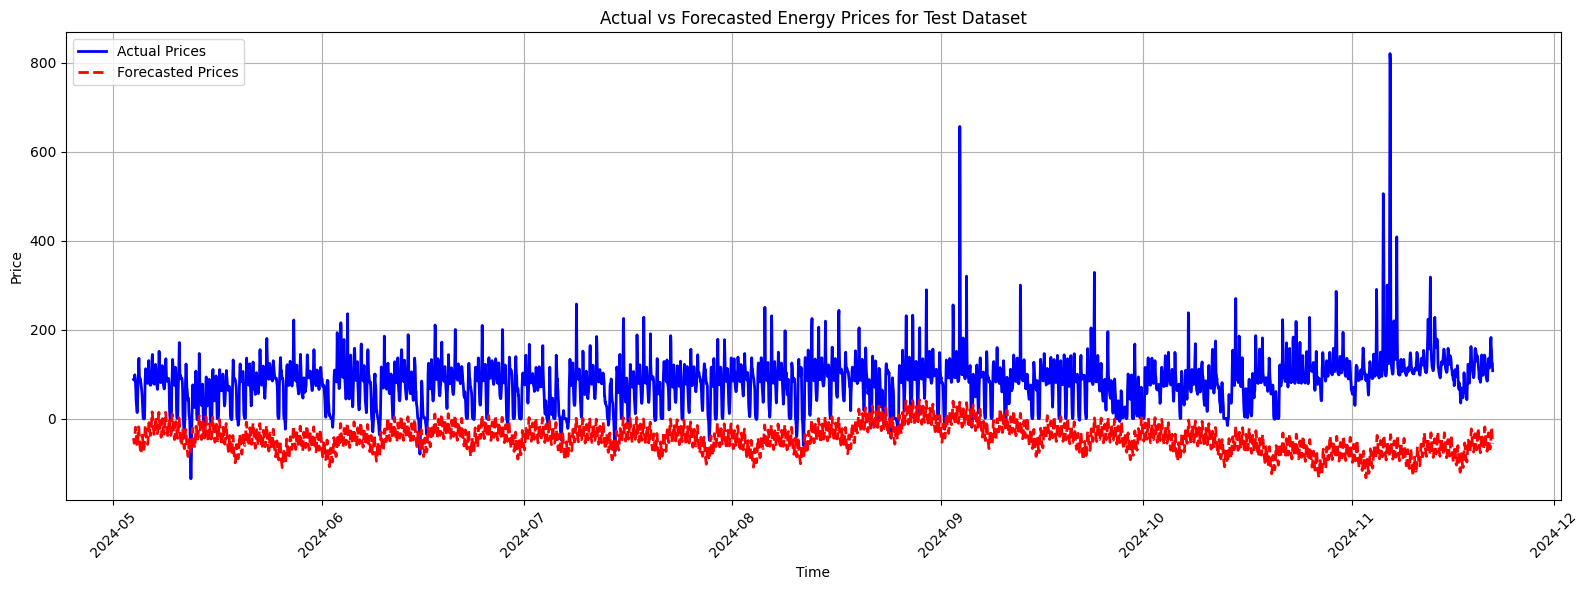

In [478]:
plt.figure(figsize=(16, 6))
plt.plot(results_df['ds'], results_df['y'], label='Actual Prices', color='blue', linewidth=2)
plt.plot(results_df['ds'], results_df['yhat'], label='Forecasted Prices', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for Test Dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Add Weather as regressor

In [479]:
# Load energy and weather data
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)  # Convert to datetime and remove timezone
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})  # Rename columns to match Prophet's expected column names

weather_data = pd.read_csv('../../data/germany_weather_average.csv')  # Adjust file path if needed
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

merged_data = pd.merge(energy_data, weather_data, on='ds', how='left')
train_data, validation_data, test_data = merged_data[:split_index], merged_data[split_index:mid_index], merged_data[mid_index:]

In [480]:
model = Prophet()

weather_columns = [col for col in weather_data.columns if col != 'ds'] 

for col in weather_columns:
    model.add_regressor(col)

model.fit(train_data) 
future = test_data[['ds'] + weather_columns]

# Generate forecast
forecast = model.predict(future)
results_df = forecast.merge(test_data, on='ds', how='left')


mae = mean_absolute_error(results_df['y'], results_df['yhat'])
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:54:03 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE): 127.64


#### + Add Energy Market Mix

In [490]:
# Load data
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)  # Convert to datetime and remove timezone
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})  # Rename columns to match Prophet's expected column names

weather_data = pd.read_csv('../../data/germany_weather_average.csv')  # Adjust file path if needed
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

market_mix = pd.read_csv('../../data/hourly_market_metrics_cleaned.csv')
market_mix['Timestamp'] = pd.to_datetime(market_mix['Timestamp']).dt.tz_localize(None)
market_mix.rename(columns={'Timestamp': 'ds'}, inplace=True)

merged_data = pd.merge(energy_data, weather_data, on='ds', how='left')
merged_data = pd.merge(market_mix, merged_data, on= 'ds' , how= 'left')
train_data, validation_data, test_data = merged_data[:split_index], merged_data[split_index:mid_index], merged_data[mid_index:]


In [482]:
model = Prophet()

# Add all columns except 'ds' and 'y' as regressors
columns = [col for col in merged_data.columns if col not in ['ds', 'y']] 

for col in columns:
    model.add_regressor(col)

# Fit the model with training data
model.fit(train_data) 

future = test_data[['ds'] + columns] # not taking y
forecast = model.predict(future)

results_df = forecast[['ds', 'yhat']].merge(test_data[['ds', 'y']], on='ds', how='left')


# RMSE - MAE
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


23:54:09 - cmdstanpy - INFO - Chain [1] start processing
23:56:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 57.26
Root Mean Squared Error (RMSE): 62.59


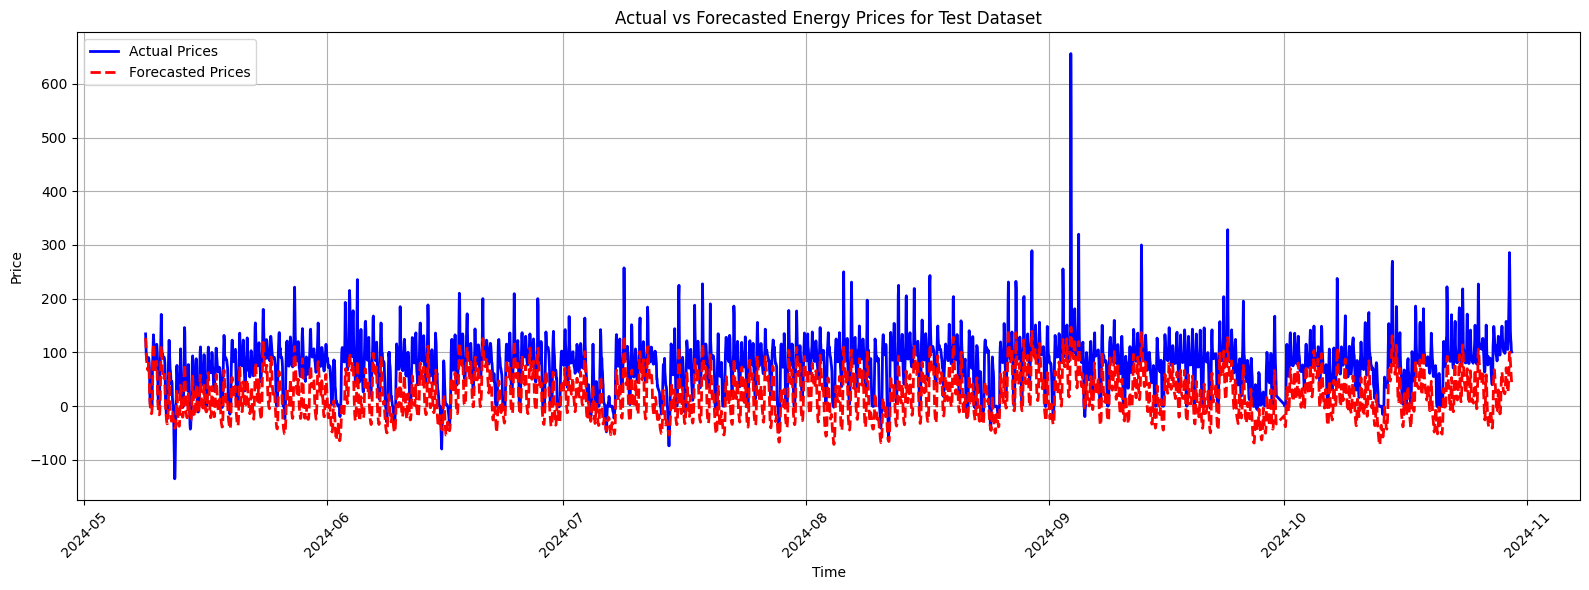

In [483]:
# Plot forecast and actual values
plt.figure(figsize=(16, 6))
plt.plot(results_df['ds'], results_df['y'], label='Actual Prices', color='blue', linewidth=2)
plt.plot(results_df['ds'], results_df['yhat'], label='Forecasted Prices', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Forecasted Energy Prices for Test Dataset")
plt.xlabel("Time")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### Create Moving Average Features


In [501]:
# Load data
energy_data = pd.read_csv('../../data/day_ahead_energy_prices.csv')
energy_data['Datetime'] = pd.to_datetime(energy_data['Datetime']).dt.tz_localize(None)  # Convert to datetime and remove timezone
energy_data = energy_data.rename(columns={'Datetime': 'ds', 'hourly day-ahead energy price': 'y'})  # Rename columns to match Prophet's expected column names

weather_data = pd.read_csv('../../data/germany_weather_average.csv')  # Adjust file path if needed
weather_data['date'] = pd.to_datetime(weather_data['date']).dt.tz_localize(None)
weather_data.rename(columns={'date': 'ds'}, inplace=True)

market_mix = pd.read_csv('../../data/hourly_market_mix_cleaned.csv')
market_mix['Timestamp'] = pd.to_datetime(market_mix['Timestamp']).dt.tz_localize(None)
market_mix.rename(columns={'Timestamp': 'ds'}, inplace=True)

merged_data = pd.merge(energy_data, weather_data, on='ds', how='left')
merged_data = pd.merge(market_mix, merged_data, on= 'ds' , how= 'left')

In [502]:
def create_features(df, include_target=True):
    df = df.copy()

    # Extract temporal features
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['weekofyear'] = df['ds'].dt.isocalendar().week

    if include_target:
        # Moving averages for hours (if 'y' is available)
        for window in range(2, 24):  # Using range for hours from 2 to 23
            df[f'ma_{int(window)}_hours'] = df['y'].rolling(window=window).mean()

        # Moving averages for days (1 day, 3 days, 1 week)
        for window in [24, 72, 168]:  # Corresponding to 1 day, 3 days, 7 days
            df[f'ma_{int(window / 24)}_days'] = df['y'].rolling(window=window).mean()

        # Moving averages for months (assuming 30 days per month)
        for window in [1, 2, 3]:  # 1 month, 2 months, 3 months
            hours_in_month = window * 30 * 24
            df[f'ma_{int(window)}_month'] = df['y'].rolling(window=hours_in_month).mean()

        # Rolling averages for selected energy-related columns
        energy_columns = [col for col in merged_data.columns if col not in ['ds', 'y']]

        for window in [3, 6, 12]:  # 3, 6, and 12 hours
            for col in energy_columns:
                df[f'{col}_ma_{int(window)}_hours'] = df[col].rolling(window=window).mean()

        # Fill NaN values in moving averages with interpolation or medians
        for column in df.columns:
            if 'ma_' in column:  # Apply only to moving average columns
                df[column] = df[column].interpolate(method='linear').fillna(df[column].median())

    return df

merged_data = create_features(merged_data)
train_data, validation_data, test_data = merged_data[:split_index], merged_data[split_index:mid_index], merged_data[mid_index:]
energy_columns = [col for col in merged_data.columns if col not in ['ds', 'y']]



In [503]:
model = Prophet()

# Add time-based regressors
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')

# Add moving average regressors       
model.add_regressor('hour')
model.add_regressor('ma_2_hours') 
model.add_regressor('ma_3_hours')  
model.add_regressor('ma_4_hours')
model.add_regressor('ma_5_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_7_hours')
model.add_regressor('ma_8_hours')
model.add_regressor('ma_9_hours')

model.add_regressor('ma_1_days')
# model.add_regressor('ma_3_days')
model.add_regressor('ma_7_days')


# model.add_regressor('Biomass') 
# model.add_regressor('Hard Coal')
model.add_regressor('Hydro')
# model.add_regressor('Lignite')
# model.add_regressor('Natural Gas')
# model.add_regressor('Nuclear')
# model.add_regressor('Other')
model.add_regressor('Pumped storage generation')
model.add_regressor('Solar')
# model.add_regressor('Wind offshore')
model.add_regressor('Wind onshore')

# Add regressors for the provided columns
model.add_regressor('temperature_2m')
model.add_regressor('Precipitation (rain/snow)')
# model.add_regressor('wind_speed_100m')
model.add_regressor('direct_radiation')

# model.add_regressor('ma_10_hours')
# model.add_regressor('ma_11_hours')
# model.add_regressor('ma_12_hours')
# model.add_regressor('ma_13_hours')
# model.add_regressor('ma_14_hours')
# model.add_regressor('ma_15_hours')
# model.add_regressor('ma_16_hours')
# model.add_regressor('ma_17_hours')
# model.add_regressor('ma_18_hours')
# model.add_regressor('ma_19_hours')
# model.add_regressor('ma_20_hours')
# model.add_regressor('ma_21_hours')
# model.add_regressor('ma_22_hours')
# model.add_regressor('ma_23_hours')


model.fit(train_data)

future = test_data[['ds'] + energy_columns]
forecast = model.predict(future)

results_df = forecast.merge(test_data, on='ds', how='left')


# RMSE - MAE
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

00:06:05 - cmdstanpy - INFO - Chain [1] start processing
00:06:34 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 4.19
Root Mean Squared Error (RMSE): 7.39


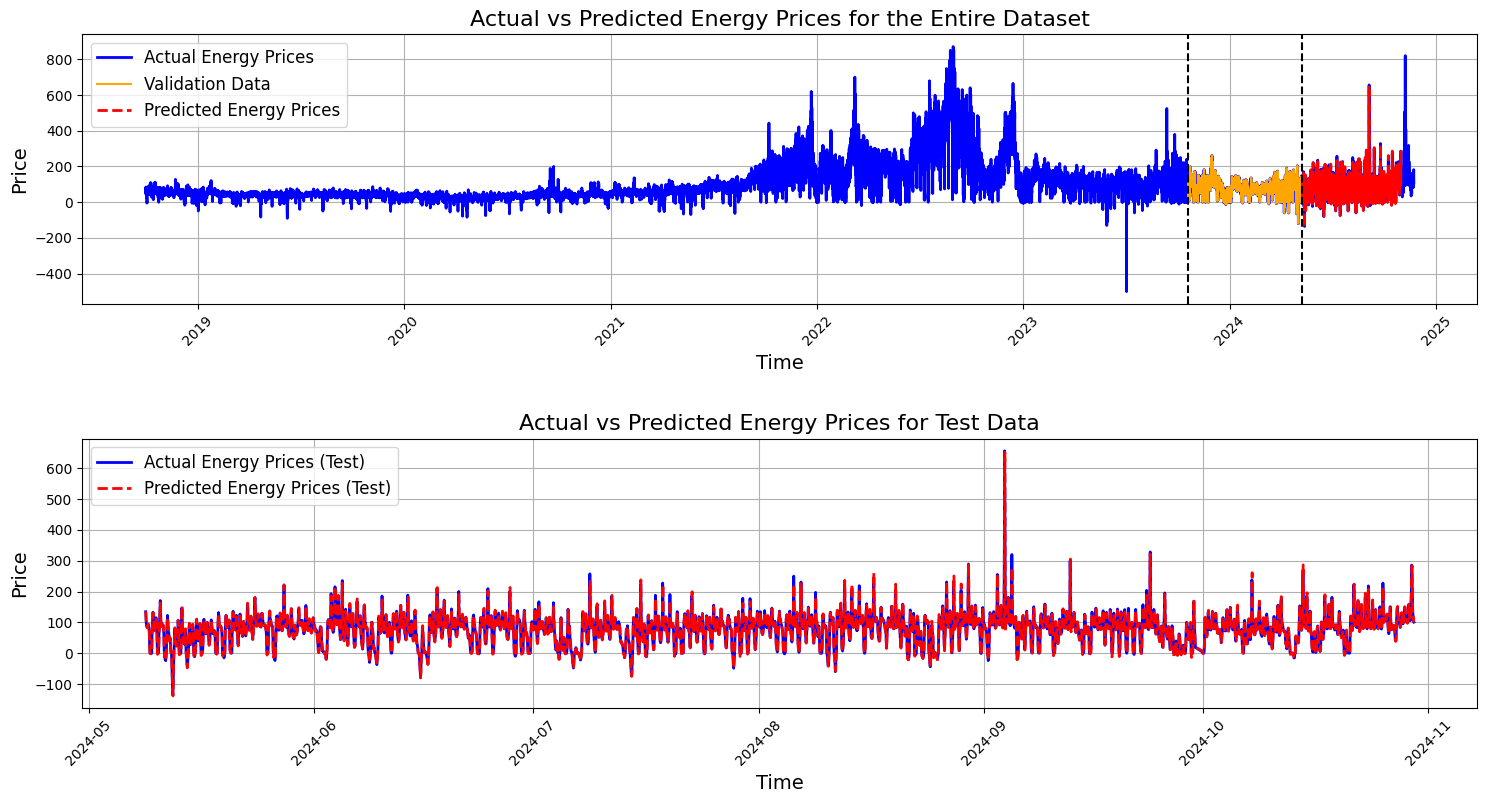

In [487]:
plt.figure(figsize=(18, 14))

# 1st Plot: Actual and predicted values for the entire dataset (training + test)
plt.subplot(3, 1, 1)
plt.plot(energy_data['ds'], energy_data['y'], label='Actual Energy Prices', color='blue', linewidth=2)
plt.plot(validation_data['ds'], validation_data['y'], label='Validation Data', color='orange')
plt.plot(results_df['ds'], results_df['yhat'], label='Predicted Energy Prices', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Energy Prices for the Entire Dataset", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Add vertical lines to separate train, validation, and test data
plt.axvline(x=train_data['ds'].iloc[-1], color='black',  linestyle='--')
plt.axvline(x=validation_data['ds'].iloc[-1], color='black', linestyle='--')

plt.subplots_adjust(hspace=0.5) 
# 2nd Plot: Actual and predicted values for only the test data
plt.subplot(3, 1, 2)
plt.plot(test_data['ds'], test_data['y'], label='Actual Energy Prices (Test)', color='blue', linewidth=2)
plt.plot(results_df['ds'], results_df['yhat'], label='Predicted Energy Prices (Test)', color='red', linestyle='dashed', linewidth=2)
plt.title("Actual vs Predicted Energy Prices for Test Data", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

### Growth

In [493]:
model = Prophet(growth='linear')

# Add time-based regressors
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')

# Add moving average regressors       
model.add_regressor('hour')
model.add_regressor('ma_2_hours') 
model.add_regressor('ma_3_hours')  
model.add_regressor('ma_4_hours')
model.add_regressor('ma_5_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_7_hours')
model.add_regressor('ma_8_hours')
model.add_regressor('ma_9_hours')

model.add_regressor('ma_1_days')
model.add_regressor('ma_7_days')

model.add_regressor('Hydro')
model.add_regressor('Pumped storage generation')
model.add_regressor('Solar')
model.add_regressor('Wind onshore')

model.add_regressor('temperature_2m')
model.add_regressor('Precipitation (rain/snow)')

# Prophet modelini eğitiyoruz
model.fit(train_data)
future = test_data[['ds'] + energy_columns]

# Tahmin yapıyoruz
forecast = model.predict(future)
results_df = forecast.merge(test_data, on='ds', how='left')

# RMSE - MAE
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

00:00:05 - cmdstanpy - INFO - Chain [1] start processing
00:00:30 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 4.19
Root Mean Squared Error (RMSE): 7.39


### Holiday


In [500]:
holiday_dates = [
    '2023-07-02 14:00:00', 
    '2022-08-29 19:00:00',
    '2022-08-29 20:00:00',
    '2022-08-30 19:00:00',
    '2022-08-24 19:00:00',
    '2022-08-29 18:00:00',
]

holidays = pd.DataFrame({
    'holiday': 'special_event',
    'ds': pd.to_datetime(holiday_dates),
    'lower_window': 0,
    'upper_window': 0
})


model = Prophet(
    growth='linear',
    holidays=holidays
)


model.add_regressor('dayofweek')
model.add_regressor('dayofyear')
model.add_regressor('hour')
model.add_regressor('ma_2_hours')
model.add_regressor('ma_3_hours')
model.add_regressor('ma_4_hours')
model.add_regressor('ma_5_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_7_hours')
model.add_regressor('ma_8_hours')
model.add_regressor('ma_9_hours')
model.add_regressor('ma_1_days')
model.add_regressor('ma_7_days')
model.add_regressor('Hydro')
model.add_regressor('Pumped storage generation')
model.add_regressor('Solar')
model.add_regressor('Wind onshore')
model.add_regressor('temperature_2m')
model.add_regressor('Precipitation (rain/snow)')


model.fit(train_data)

future = test_data[['ds'] + energy_columns]
forecast = model.predict(future)

results_df = forecast.merge(test_data, on='ds', how='left')

# RMSE - MAE
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

00:05:18 - cmdstanpy - INFO - Chain [1] start processing
00:05:48 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 4.19
Root Mean Squared Error (RMSE): 7.40


#### Fourier Order 

In [ ]:
# Prophet modelini başlatma ve parametreleri ayarlama
model = Prophet()

# Özel sezonluk etkiler ekleme (Custom Seasonality)
model.add_seasonality(name='hourly', period=1, fourier_order=2)  # Saatlik sezonluk etki
model.add_seasonality(name='daily', period=24, fourier_order=12)  # Günlük sezonluk etki
model.add_seasonality(name='weekly', period=7 * 24, fourier_order=1)  # Haftalık sezonluk etki
model.add_seasonality(name='monthly', period=30.5 * 24, fourier_order=30)  # Aylık sezonluk etki
model.add_seasonality(name='yearly', period=365.25 * 24, fourier_order=1)  # Yıllık sezonluk etki

# Regresörleri ekleme
# Zaman temelli regresörler
model.add_regressor('dayofweek')
model.add_regressor('dayofyear')

# Hareketli ortalama (Moving Average) regresörleri
model.add_regressor('hour')
model.add_regressor('ma_2_hours') 
model.add_regressor('ma_3_hours')  
model.add_regressor('ma_4_hours')
model.add_regressor('ma_5_hours')
model.add_regressor('ma_6_hours')
model.add_regressor('ma_7_hours')
model.add_regressor('ma_8_hours')
model.add_regressor('ma_9_hours')

model.add_regressor('ma_1_days')
model.add_regressor('ma_7_days')

# Enerji kaynaklarına ilişkin regresörler
model.add_regressor('Hydro')
model.add_regressor('Pumped storage generation')
model.add_regressor('Solar')
model.add_regressor('Wind onshore')

# Hava durumu regresörleri
model.add_regressor('temperature_2m')
model.add_regressor('Precipitation (rain/snow)')
model.add_regressor('direct_radiation')

# Modeli eğit
model.fit(train_data)

# Test verisi ile tahmin yapmak için gelecekteki tarihleri oluştur
future = test_data[['ds'] + energy_columns]
forecast = model.predict(future)

# Tahmin sonuçlarını birleştir
results_df = forecast.merge(test_data, on='ds', how='left')

# Performans metriklerini hesapla
mae = mean_absolute_error(results_df['y'], results_df['yhat'])
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = mean_squared_error(results_df['y'], results_df['yhat'])
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
